In [99]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from metric import apk, mapk
from utils import plot_images

In [ ]:
dataset = '10'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [ ]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"week: {week}")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        tr = transactions.query(
            "user in @target_users and @week_start <= week <= @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)

        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank()

        candidates = gr_week.merge(gr_volume, on=['user', 'item'])
        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank']].rename(
            columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 24
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_popular_index_group_name(
            strategy: str,
            transactions: pd.DataFrame,
            items: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int,
            index_group_name: str) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 3
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(items[['item', 'index_group_name']], on='item').query(
            "index_group_name == @index_group_name").drop('index_group_name', axis=1).reset_index(drop=True)

        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_end: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week == @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query(
            "item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("ratio >= 0.02").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop(
            ['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename(
            {'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(
            item2item,
            on='item').drop(
            'item',
            axis=1).rename(
            columns={
                'item_with': 'item'}).rename(
                    columns=replace)

        candidates['strategy'] = strategy
        return candidates

    candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, week + 3)
    candidates_popular = create_candidates_popular('pop', transactions, target_users, week, week)
    candidates_cooc = create_candidates_cooc('cooc', transactions, week, week + 9, candidates_repurchase)
    candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
    ]

    candidates = pd.concat(candidates).reset_index(drop=True)
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    return candidates


In [ ]:
# valid: week=1
# train: week=2..1+num_train_weeks
num_train_weeks = 3
candidates = []
for week in range(1, 2+num_train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

week: 2
duplicates: 1.0759621211924164
            strategy   volume     ratio
0                pop  1655616  0.500286
1  same_product_code   937928  0.283418
2               cooc   555333  0.167808
3         repurchase   160464  0.048488
week: 3
duplicates: 1.0792051035270294
            strategy   volume     ratio
0                pop  1728456  0.500797
1  same_product_code   988789  0.286489
2               cooc   563944  0.163395
3         repurchase   170219  0.049319
week: 4
duplicates: 1.0766028849037856
            strategy   volume     ratio
0                pop  1819728  0.511573
1  same_product_code  1027992  0.288995
2               cooc   532820  0.149790
3         repurchase   176585  0.049643
week: 5
duplicates: 1.0754538392446016
            strategy   volume     ratio
0                pop  1926072  0.515089
1  same_product_code  1071744  0.286617
2               cooc   552246  0.147687
3         repurchase   189234  0.050607


In [ ]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"week: {week}")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [ ]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], 1+idx)


week: 1
Recall: 0.07782789339721516
            strategy       y   volume    recall  hit_ratio
0                pop  8434.0  1655616  0.039461   0.005094
1  same_product_code  5446.0   937928  0.025481   0.005806
2         repurchase  5014.0   160464  0.023460   0.031247
3               cooc  1062.0   555333  0.004969   0.001912
week: 2
Recall: 0.06943530340924049
            strategy       y   volume    recall  hit_ratio
0                pop  7196.0  1728456  0.031574   0.004163
1  same_product_code  5721.0   988789  0.025102   0.005786
2         repurchase  5185.0   170219  0.022750   0.030461
3               cooc  1233.0   563944  0.005410   0.002186
week: 3
Recall: 0.07019246116753615
            strategy       y   volume    recall  hit_ratio
0                pop  8558.0  1819728  0.035947   0.004703
1  same_product_code  5360.0  1027992  0.022514   0.005214
2         repurchase  4970.0   176585  0.020876   0.028145
3               cooc  1136.0   532820  0.004772   0.002132
week: 4

In [ ]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby(
        'user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


def calc_query_groups(labels):
    """
    userでソートして、データセットに与える必要があるグループを計算する
    user, y
    """
    df = labels.sort_values(by='user').reset_index(drop=True)
    group = get_query_group(df)
    return df, group


In [ ]:
for idx in range(len(candidates)):
    candidates[idx]['week'] = 1+idx

valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 3309341 -> 885063
drop trivial queries: 3451408 -> 884004
drop trivial queries: 3557125 -> 907018
drop trivial queries: 3739296 -> 910201


In [ ]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"week: {week}")
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['week'].min().reset_index(name='item_week_min')
    tmp['item_week_min'] -= week
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
    df = df.merge(tmp, on='item', how='left')

    # # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['week'].min().reset_index(name='user_week_min')
    # tmp['user_week_min'] -= week
    # df = df.merge(tmp, on='user', how='left')

    # # user volume features
    # num_weeks = 1
    # week_end = week + num_weeks
    # tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
    # df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['week'].min().reset_index(name='user_item_week_min')
    tmp['user_item_week_min'] -= week
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')

    assert len(df) == n_original
    return df


valid_all = attach_features(transactions, users, items, valid_all, 2)
for idx in range(len(candidates)):
    candidates[idx] = attach_features(transactions, users, items, candidates[idx], 2+idx)

In [ ]:
datasets = []
for idx in range(len(candidates)):
    datasets.append(calc_query_groups(candidates[idx]))

valid, group_valid = datasets[0]

def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx][0] for idx in range(begin, begin+num)])
    group_train = []
    for idx in range(begin, begin+num):
        group_train += datasets[idx][1]
    return train, group_train

train, group_train = concat_train(datasets, 1, num_train_weeks)

In [ ]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_repurchase_week_rank', 'cooc_repurchase_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_repurchase_week_rank', 'same_product_code_repurchase_volume_rank', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_week_min', 'item_volume', 'user_item_week_min', 'user_item_volume']


In [ ]:
train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)


In [ ]:
params = {
    'objective': 'xendcg',
    'boosting_type': 'gbdt',
    'learning_rate': 1e-6,
    'num_leaves': 255,
    'min_data_in_leaf': 100,
    'metric': 'map',
    'eval_at': 12,
}

model = lgb.train(
    params, train_dataset, valid_sets=[
        train_dataset, valid_dataset], num_boost_round=1000, callbacks=[
            lgb.early_stopping(20)])


[LightGBM] [Info] Total groups: 38901, total data: 2701223
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5241
[LightGBM] [Info] Number of data points in the train set: 2701223, number of used features: 41
[LightGBM] [Info] Total groups: 12606, total data: 885063
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	training's map@12: 0.290856	valid_1's map@12: 0.254492


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

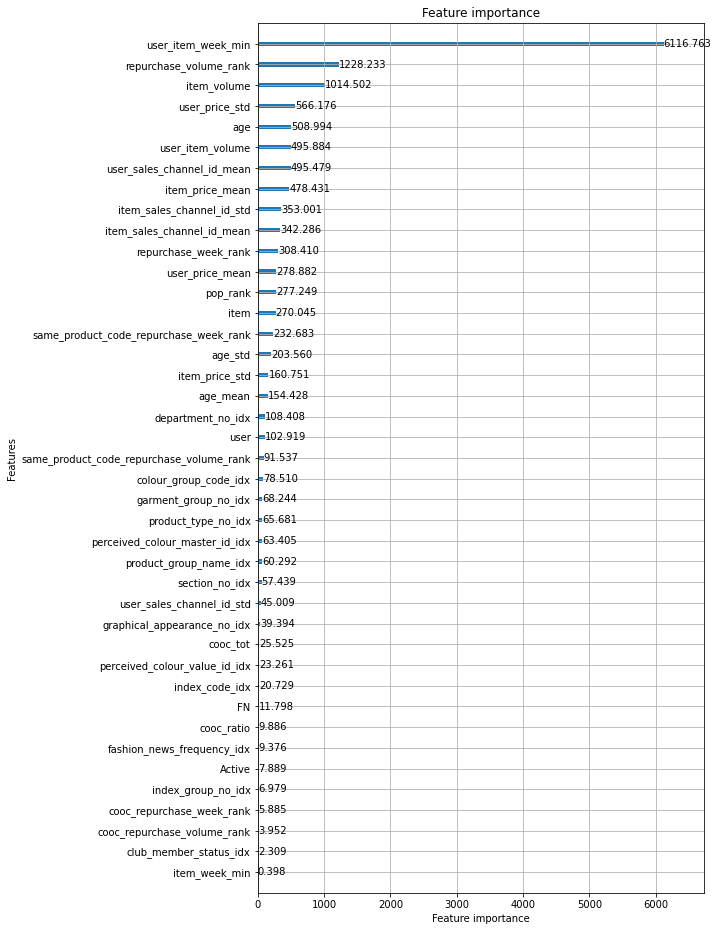

In [ ]:
lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))


In [ ]:
valid_all['pred'] = model.predict(valid_all[feature_columns], num_iteration=model.best_iteration)
pred = valid_all.groupby(['user', 'item'])['pred'].max().reset_index()


In [ ]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(
    drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred


,user,item
0,80,"[104045, 3091, 67522, 82628, 104553, 95217, 10..."
1,86,"[27905, 33868, 100228, 98606, 102710, 102472, ..."
2,107,"[61303, 61304, 2219, 61305, 13042, 17941, 8465..."
3,117,"[104045, 3091, 67522, 82628, 104553, 95217, 10..."
4,179,"[95216, 105180, 104986, 3510, 105179, 95217, 3..."
...,...,...
68979,1371868,"[104045, 3091, 82628, 104553, 67522, 103108, 1..."
68980,1371871,"[104045, 67522, 67543, 95217, 103796, 3091, 10..."
68981,1371879,"[103668, 103669, 103670, 103665, 53892, 103666..."
68982,1371937,"[59774, 59771, 59773, 67522, 59772, 103796, 10..."


In [ ]:
gt = transactions.query("week == 1").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
merged


,user,gt,item
0,80,[28967],"[104045, 3091, 67522, 82628, 104553, 95217, 10..."
1,86,[87371],"[27905, 33868, 100228, 98606, 102710, 102472, ..."
2,107,"[69711, 77256, 33872]","[61303, 61304, 2219, 61305, 13042, 17941, 8465..."
3,117,[97391],"[104045, 3091, 67522, 82628, 104553, 95217, 10..."
4,179,"[102397, 98409, 73, 95784, 103796, 105103, 103...","[95216, 105180, 104986, 3510, 105179, 95217, 3..."
...,...,...,...
68979,1371868,"[97531, 103424]","[104045, 3091, 82628, 104553, 67522, 103108, 1..."
68980,1371871,"[94310, 91533]","[104045, 67522, 67543, 95217, 103796, 3091, 10..."
68981,1371879,"[2118, 84994, 57078, 84991, 101099, 104036, 87...","[103668, 103669, 103670, 103665, 53892, 103666..."
68982,1371937,"[67261, 70640]","[59774, 59771, 59773, 67522, 59772, 103796, 10..."


In [ ]:
mapk(merged['gt'], merged['item'])


0.02747803051887496

In [ ]:
# assert False

submission

In [ ]:
train, group_train = concat_train(datasets, 0, num_train_weeks)

[LightGBM] [Info] Total groups: 12606, total data: 885063
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5029
[LightGBM] [Info] Number of data points in the train set: 885063, number of used features: 41


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

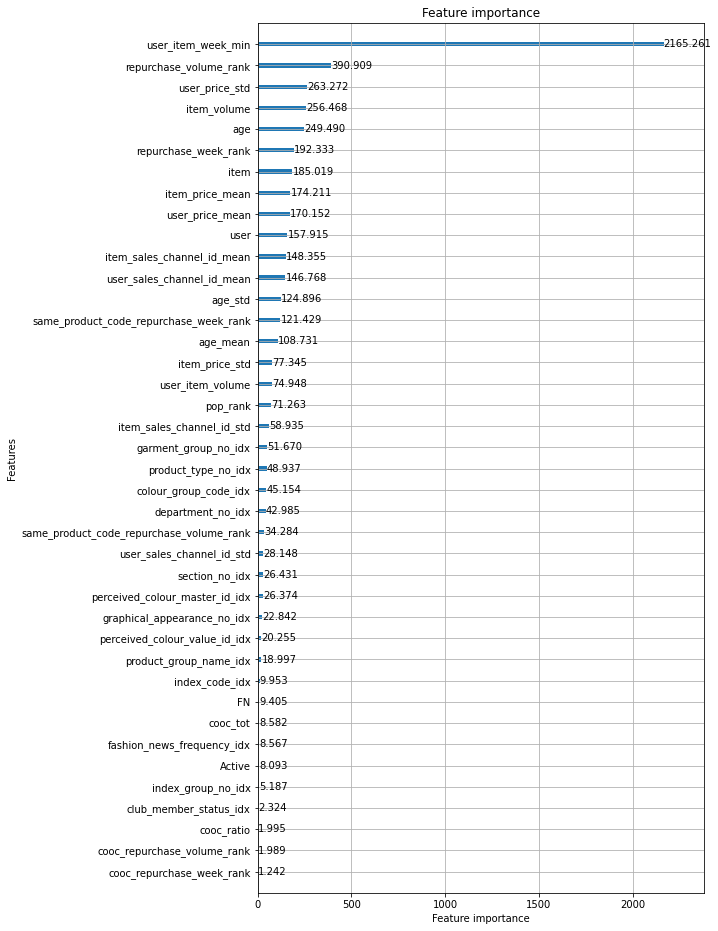

In [ ]:
train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
best_iteration = model.best_iteration
model = lgb.train(params, train_dataset, num_boost_round=best_iteration)
lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

In [ ]:
target_users = users['user'].values
target_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [ ]:
candidates = create_candidates(transactions, target_users, 1)

week: 1
duplicates: 1.0356685502212768
            strategy    volume     ratio
0                pop  32927520  0.760764
1  same_product_code   6069600  0.140233
2               cooc   3362926  0.077698
3         repurchase    922148  0.021305


In [ ]:
candidates = attach_features(transactions, users, items, candidates, 1)

In [ ]:
candidates['pred'] = model.predict(candidates[feature_columns])
pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()

KeyboardInterrupt: 

In [ ]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(
    drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred


In [ ]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [ ]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

In [ ]:
a_user = mp_user['val'].values
a_item = mp_item['val'].values

In [ ]:
pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

In [ ]:
pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
submission = pred[['customer_id', 'prediction']]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)